## Read the data

In [85]:
import iris
import numpy
import matplotlib.pyplot as plt

In [86]:
control_file = '/g/data/ua6/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/piControl/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_000101-001012.nc'
hist_file = '/g/data/ua6/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historical/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historical_r1i1p1_185001-185912.nc'
coeff_file = '/g/data/r87/dbi599/coefficients.nc'
dedrift_file = '/g/data/r87/dbi599/dedrifted.nc'

In [87]:
min_lat, max_lat = [-62.1, -61.9]
lat_subset = lambda cell: min_lat <= cell <= max_lat
lev_constraint = iris.Constraint(depth=15)
lat_constraint = iris.Constraint(latitude=lat_subset)
lon_constraint = iris.Constraint(longitude=101.25)

In [88]:
#coeff_a_cube = iris.load(coeff_file)

with iris.FUTURE.context(cell_datetime_objects=True):
    control_cube = iris.load_cube(control_file, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint)
    hist_cube = iris.load_cube(hist_file, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint)
    coeff_a_cube = iris.load_cube(coeff_file, 'coefficient a' & lev_constraint & lat_constraint & lon_constraint)
    coeff_b_cube = iris.load_cube(coeff_file, 'coefficient b' & lev_constraint & lat_constraint & lon_constraint)
    coeff_c_cube = iris.load_cube(coeff_file, 'coefficient c' & lev_constraint & lat_constraint & lon_constraint)
    coeff_d_cube = iris.load_cube(coeff_file, 'coefficient d' & lev_constraint & lat_constraint & lon_constraint)
    dedrift_cube = iris.load_cube(dedrift_file, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint)

In [89]:
print coeff_b_cube

coefficient b / (1)                 (scalar cube)
     Scalar coordinates:
          depth: 15.0 m, bound=(10.0, 21.6242351532) m
          latitude: -62.0240516663 degrees, bound=(-62.490436554, -61.5576667786) degrees
          longitude: 101.25 degrees, bound=(100.3125, 102.1875) degrees
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_CSIRO-Mk3-6-0_piControl_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.5.9
          comment: Data is stored on the native ocean T-grid on which the data was generated....
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          experiment: pre-industrial control
          experiment_id: piControl
          forcing: N/A (Pre-industrial conditions with all forcings fixed at 1850 levels)
          frequency: mon
          history: Mon Apr 18 15:03:30 2016: /g/data/r87/dbi

## Validate polynomial contruction

In [90]:
def apply_polynomial(x, a, b, c, d):
    """Evaluate cubic polynomial.

    The axis argument is not used but is required for the function to be 
      used with numpy.apply_over_axes 

    """

    result = a + b * x + c * x**2 + d * x**3 
    
    return result 

In [91]:
control_cube.coord('time').points

array([   15.5,    45. ,    74.5,   105. ,   135.5,   166. ,   196.5,
         227.5,   258. ,   288.5,   319. ,   349.5,   380.5,   410. ,
         439.5,   470. ,   500.5,   531. ,   561.5,   592.5,   623. ,
         653.5,   684. ,   714.5,   745.5,   775. ,   804.5,   835. ,
         865.5,   896. ,   926.5,   957.5,   988. ,  1018.5,  1049. ,
        1079.5,  1110.5,  1140. ,  1169.5,  1200. ,  1230.5,  1261. ,
        1291.5,  1322.5,  1353. ,  1383.5,  1414. ,  1444.5,  1475.5,
        1505. ,  1534.5,  1565. ,  1595.5,  1626. ,  1656.5,  1687.5,
        1718. ,  1748.5,  1779. ,  1809.5,  1840.5,  1870. ,  1899.5,
        1930. ,  1960.5,  1991. ,  2021.5,  2052.5,  2083. ,  2113.5,
        2144. ,  2174.5,  2205.5,  2235. ,  2264.5,  2295. ,  2325.5,
        2356. ,  2386.5,  2417.5,  2448. ,  2478.5,  2509. ,  2539.5,
        2570.5,  2600. ,  2629.5,  2660. ,  2690.5,  2721. ,  2751.5,
        2782.5,  2813. ,  2843.5,  2874. ,  2904.5,  2935.5,  2965. ,
        2994.5,  302

In [92]:
my_poly = apply_polynomial(control_cube.coord('time').points,
                           coeff_a_cube.data,
                           coeff_b_cube.data,
                           coeff_c_cube.data,
                           coeff_d_cube.data)

In [93]:
print my_poly[0:5]

[ 273.03614157  273.03639618  273.03665069  273.03691375  273.03717672]


In [94]:
numpy_poly = numpy.poly1d([float(coeff_d_cube.data), 
                           float(coeff_c_cube.data),
                           float(coeff_b_cube.data),
                           float(coeff_a_cube.data)])

In [95]:
print numpy_poly(control_cube.coord('time').points)[0:5]

[ 273.03614157  273.03639618  273.03665069  273.03691375  273.03717672]


In [96]:
print control_cube.data[0:5]

[ 272.67153931  274.03100586  273.52758789  272.86123657  272.12963867]


In [ ]:
dedrift = control_cube.data

### Plot

In [77]:
% matplotlib inline

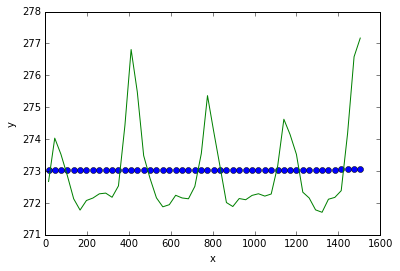

In [84]:
plt.plot(control_cube.coord('time').points[0:50], my_poly[0:50], 'o')
plt.plot(control_cube.coord('time').points[0:50], control_cube.data[0:50])
plt.ylabel('y')
plt.xlabel('x')
plt.show()

## Validate removal from historical